# ECG Split 1D-CNN Server Side
This code is the server part of ECG split 1D-CNN model for a **single** client and a server.

## Import required packages

In [1]:
import os
import socket
import struct
import pickle
import time
from pathlib import Path

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD

import tenseal as ts
from tenseal.enc_context import Context
from tenseal.tensors.ckksvector import CKKSVector
from tenseal.tensors.ckkstensor import CKKSTensor
from tenseal.tensors.plaintensor import PlainTensor

In [2]:
project_path = Path.cwd().parent.parent
print(f'project_path: {project_path}')

project_path: /home/dk/Desktop/split-learning-1D-HE


## Socket initialization

In [3]:
# Set host address and port number
host = 'localhost'
port = 10080
max_recv = 4096

# Open the server socket
s = socket.socket()
s.bind((host, port))
s.listen(5)

# Wait for Client
conn, addr = s.accept()
print('Conntected with', addr)

Conntected with ('127.0.0.1', 51382)


Required socket functions for training

In [4]:
def send_msg(sock, msg):
    # prefix each message with a 4-byte length in network byte order
    msg = struct.pack('>I', len(msg)) + msg
    sock.sendall(msg)

def recv_msg(sock):
    # read message length and unpack it into an integer
    raw_msglen = recvall(sock, 4)
    if not raw_msglen:
        return None
    msglen = struct.unpack('>I', raw_msglen)[0]
    # read the message data
    return recvall(sock, msglen)

def recvall(sock, n):
    # helper function to receive n bytes or return None if EOF is hit
    data = b''
    while len(data) < n:
        packet = sock.recv(n - len(data))
        if not packet:
            return None
        data += packet
    return data

## Define ECG server model
Server side has **2 fully connected layers**.


In [5]:
class EcgServer(nn.Module):
    def __init__(self):
        super(EcgServer, self).__init__()
        checkpoint = torch.load("init_weight.pth")
        self.linear3_weight: torch.Tensor = checkpoint["linear3.weight"]  # [128, 512]
        self.linear3_bias: torch.Tensor = checkpoint["linear3.bias"]  # [128]
        self.linear4_weight: torch.Tensor = checkpoint["linear4.weight"]  # [5, 128]
        self.linear4_bias: torch.Tensor = checkpoint["linear4.bias"]  # [5]

    def enc_linear(self, 
                    enc_x: CKKSTensor, 
                    W: torch.Tensor, 
                    b: torch.Tensor) -> CKKSTensor:
        """
        The linear layer on homomorphic encrypted data
        Based on https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        """
        Wt = torch.transpose(W, 0, 1)
        return enc_x.mm(Wt) + b

    @staticmethod
    def approx_leaky_relu(enc_x: CKKSTensor):
        # 2.30556314780491e-19*x**5 - 0.000250098672095587*x**4 - 
        # 2.83384427035571e-17*x**3 + 0.0654264479654812*x**2 + 
        # 0.505000000000001*x + 0.854102848838318
        return enc_x.polyval([0.854102848838318, 0.505000000000001, 0.0654264479654812])

    def forward(self, enc_x: CKKSTensor) -> CKKSTensor:
        x = self.enc_linear(enc_x, self.linear3_weight, self.linear3_bias)  # [batch_size, 128]
        x = EcgServer.approx_leaky_relu(x)
        x = self.enc_linear(x, self.linear4_weight, self.linear4_bias)  # [batch_size, 5]
        return x

    def backward(self):
        """ 
        Calculates the gradients
        """
        raise NotImplementedError

    def update_params(self):
        """
        Update the parameters based on the gradients calculated in backward()
        """
        raise NotImplementedError

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)
ecg_server = EcgServer()
ecg_server.to(device)

EcgServer()

### Set random seed

In [7]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Training process

### Set other hyperparameters in the model
Hyperparameters here should be same with the client side.

In [19]:
msg = recv_msg(conn)  # receive client message from socket
msg = pickle.loads(msg)  # deserialize
msg

{'batch_size': 2, 'total_batch': 6623, 'epoch': 400}

In [20]:
batch_size = msg['batch_size']
total_batch = msg['total_batch']
epoch = msg['epoch']

In [22]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
# we will define our own upadte_params() function
# optimizer = Adam(ecg_server.parameters(), lr=lr)

### Training and testing loop

In [23]:
train_losses = list()
train_accs = list()
test_losses = list()
test_accs = list()
best_test_acc = 0  # best test accuracy

for e in range(epoch):
    print("Epoch {} - ".format(e+1), end='')
    
    train_loss = 0.0
    correct, total = 0, 0
    for i in range(total_batch):
        msg = recv_msg(conn)  # receive client message from socket
        print(msg)

Epoch 1 - 

In [12]:
best_test_acc_epoch = np.array(test_accs).argmax() + 1
print('Best test accuracy {:.2f}% in epoch {}.'.format(best_test_acc*100, best_test_acc_epoch))

Best test accuracy 98.44% in epoch 314.


In [13]:
df = pd.DataFrame({  # save model training process into csv file
        'loss': train_losses,
        'test_loss': test_losses,
        'acc': train_accs,
        'test_acc': test_accs
    })
df.to_csv(os.path.join('csv', 'loss_and_acc.csv'))

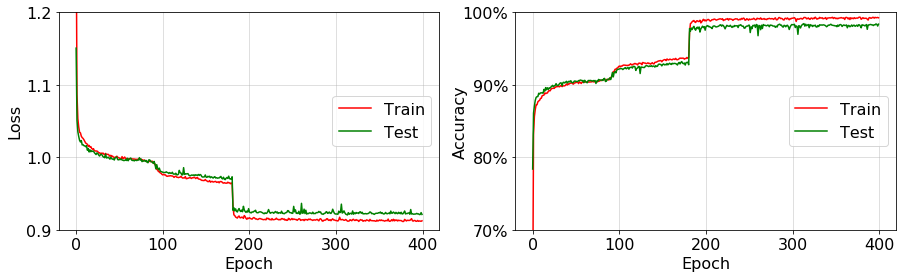

In [12]:
df = pd.read_csv(os.path.join('csv', 'loss_and_acc.csv'))
test_accs = df['test_acc']
train_accs = df['acc']
test_losses = df['test_loss']
train_losses = df['loss']

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(train_losses, color='red')
ax[0].plot(test_losses, color='green')
ax[0].set_xticks([0, 100, 200, 300, 400])
ax[0].set_xlabel('Epoch', size=16)
ax[0].set_ylabel('Loss', size=16)
ax[0].set_ylim(0.9, 1.1)
ax[0].set_yticks([0.9, 1.0, 1.1, 1.2])
ax[0].grid(alpha=0.5)
ax[0].tick_params(labelsize=16)
ax[0].legend(['Train', 'Test'], loc='right', fontsize=16)


ax[1].set_ylim(0.7, 1.0)
ax[1].set_yticks([0.7, 0.8, 0.9, 1.0])
ax[1].plot(train_accs, color='red')
ax[1].plot(test_accs, color='green')
yt = ax[1].get_yticks()
ax[1].set_yticklabels(['{:,.0%}'.format(x) for x in yt])
ax[1].set_xticks([0, 100, 200, 300, 400])
ax[1].set_xlabel('Epoch', size=16)
ax[1].set_ylabel('Accuracy', size=16, labelpad=-5)
ax[1].grid(alpha=0.5)
ax[1].tick_params(labelsize=16)
ax[1].legend(['Train', 'Test'], loc='right', fontsize=16)

fig.savefig('loss_acc_conv2_split_seed.pdf', bbox_inches='tight')